In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)

Files already downloaded and verified


In [26]:
#images = map(Image.open, ['Test1.jpg', 'Test2.jpg', 'Test3.jpg'])
def downscale(images, s=32):
    scaled = []
    for image in images:
        scaled.append(image.resize((s,s)))
    return scaled

def hstitch(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]

    return new_im

def vstitch(images):
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for im in images:
      new_im.paste(im, (0,y_offset))
      y_offset += im.size[1]

    return new_im

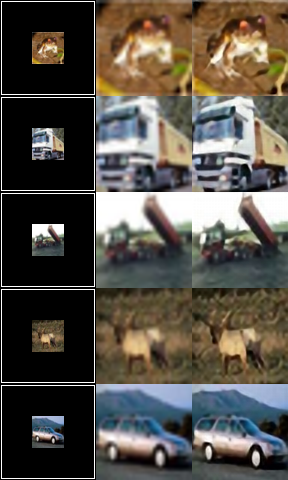

In [33]:
import argparse
import torch
from torch.autograd import Variable
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np

from IPython.display import display

in_arrs = []
in_images = []
out_images = []
#in_padded = []
for i in range(5):
    input_image = trainset.train_data[i]
    in_arrs.append(input_image)
    padded = np.pad(input_image, ((30, 30), (30, 30), (0, 0)), mode='constant', constant_values=0)
    padded = np.pad(padded, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=255)
    padded = np.pad(padded, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    #in_padded.append(padded)
    model = 'model_epoch_100.pth'
    cuda = True

    padded_img = Image.fromarray(padded)
    orig_img = Image.fromarray(input_image)
    in_images.append(padded_img)
    img = orig_img.convert('YCbCr')
    y, cb, cr = img.split()

    model = torch.load(model)
    input = Variable(ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    
    if cuda:
        model = model.cuda()
        input = input.cuda()

    out = model(input)
    out = out.cpu()
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    out_images.append(out_img)
    
bicubic = [Image.fromarray(img).resize((96, 96), Image.BICUBIC) for img in in_arrs]
    
#display(stitch(in_images))
#scaled = downscale(out_images)
#display(stitch(scaled))
#display(stitch(out_images))
#display(stitch(bicubic))

image_groups = zip(in_images, bicubic, out_images)
hlist = []
for group in image_groups:
    hlist.append(hstitch(group))
display(vstitch(hlist))